Wing Man Casca, Kwok<br>
Sep 18 2022<br>
CS 7180 Advanced Perception

Remark: Most of the coding here is referenced from https://www.kaggle.com/code/balraj98/single-image-super-resolution-gan-srgan-pytorch/notebook by BALRAJ ASHWATH.  Having said that, inspired by the benefits of super resolution, I have modified and created new codes with an aim of scaling a realistically sized image (850 x 850) to 3x to 2500 x 2500, instead of eyeing on the comparing the downscaled image with it's upscaled version.  

In [5]:
#Import Libraries
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
import cv2

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [6]:
#Define Dataset and transform images
class ImageDataset(Dataset):
    
    #Define normalization parameters 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    def __init__(self, files, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(ImageDataset.mean, ImageDataset.std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(ImageDataset.mean, ImageDataset.std),
            ]
        )
        self.files = files
    
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

In [7]:
#Define Neural Networks
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):

    def __init__(self, channels: int) -> None:
        super(ResidualBlock, self).__init__()
        self.rcb = nn.Sequential(
            nn.Conv2d(channels, channels, (3, 3), (1, 1), (1, 1), bias=False),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, (3, 3), (1, 1), (1, 1), bias=False),
            nn.BatchNorm2d(channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.rcb(x)
        out = torch.add(out, identity)

        return out


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


RuntimeError: CUDA out of memory. Tried to allocate 1.49 GiB (GPU 0; 15.90 GiB total capacity; 13.08 GiB already allocated; 1.21 GiB free; 13.98 GiB reserved in total by PyTorch)

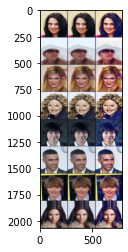

In [8]:
#Main function
def main(argv):
    
    # Define hyperparameters
    load_pretrained_models = True
    n_epochs = 1
    dataset_path = "../input/celeba-dataset/img_align_celeba/img_align_celeba"
    batch_size = 16
    lr = 0.0001          # adam: learning rate
    b1 = 0.5             # adam: decay of first order momentum of gradient
    b2 = 0.999           # adam: decay of second order momentum of gradient
    n_cpu = 8            # number of cpu threads to use during batch generation
    hr_height = 256      # high res. image height
    hr_width = 256       # high res. image width
    channels = 3

    os.makedirs("images", exist_ok=True)
    os.makedirs("saved_models", exist_ok=True)

    cuda = torch.cuda.is_available()
    hr_shape = (hr_height, hr_width)
    
    #Define Dataloaders
    train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.*")), test_size=0.02, random_state=42)
    train_dataloader = DataLoader(ImageDataset(train_paths, hr_shape=hr_shape), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
    test_dataloader = DataLoader(ImageDataset(test_paths, hr_shape=hr_shape), batch_size=int(batch_size*0.75), shuffle=True, num_workers=n_cpu)

    # Initialize generator and discriminator
    generator = GeneratorResNet()
    discriminator = Discriminator(input_shape=(channels, *hr_shape))
    feature_extractor = FeatureExtractor()

    # Set feature extractor to inference mode
    feature_extractor.eval()

    # Losses
    criterion_GAN = torch.nn.MSELoss()
    criterion_content = torch.nn.L1Loss()

    if cuda:
        generator = generator.cuda()
        discriminator = discriminator.cuda()
        feature_extractor = feature_extractor.cuda()
        criterion_GAN = criterion_GAN.cuda()
        criterion_content = criterion_content.cuda()

    # Load pretrained models
    '''
    if load_pretrained_models:
        generator.load_state_dict(torch.load("../input/generatorpth/generator.pth"))
        discriminator.load_state_dict(torch.load("../input/discriminatorpth/discriminator.pth"))
    '''
    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

    Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
    
    #To train and test the model
    train_gen_losses, train_disc_losses, train_counter = [], [], []
    test_gen_losses, test_disc_losses = [], []
    test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]

    for epoch in range(n_epochs):

        ### Training
        gen_loss, disc_loss = 0, 0
        tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))

        for batch_idx, imgs in enumerate(tqdm_bar):
            generator.train(); discriminator.train()

            imgs_lr = Variable(imgs["lr"].type(Tensor))
            imgs_hr = Variable(imgs["hr"].type(Tensor))

            valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
            fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

            ### Train Generator
            optimizer_G.zero_grad()
            # Generate a high resolution image from low resolution input
            gen_hr = generator(imgs_lr)
            # Adversarial loss
            loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
            # Content loss
            gen_features = feature_extractor(gen_hr)
            real_features = feature_extractor(imgs_hr)
            loss_content = criterion_content(gen_features, real_features.detach())
            # Total loss
            loss_G = loss_content + 1e-3 * loss_GAN
            loss_G.backward()
            optimizer_G.step()

            ### Train Discriminator
            optimizer_D.zero_grad()
            # Loss of real and fake images
            loss_real = criterion_GAN(discriminator(imgs_hr), valid)
            loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
            # Total loss
            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()
            optimizer_D.step()

            gen_loss += loss_G.item()
            train_gen_losses.append(loss_G.item())
            disc_loss += loss_D.item()
            train_disc_losses.append(loss_D.item())
            #train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
            tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

        # Testing
        gen_loss, disc_loss = 0, 0
        tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
        
        for batch_idx, imgs in enumerate(tqdm_bar):

            generator.eval(); discriminator.eval()

            imgs_lr = Variable(imgs["lr"].type(Tensor))
            imgs_hr = Variable(imgs["hr"].type(Tensor))

            valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
            fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

            ### Eval Generator
            # Generate a high resolution image from low resolution input
            gen_hr = generator(imgs_lr)
            # Adversarial loss
            loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
            # Content loss
            gen_features = feature_extractor(gen_hr)
            real_features = feature_extractor(imgs_hr)
            loss_content = criterion_content(gen_features, real_features.detach())
            # Total loss
            loss_G = loss_content + 1e-3 * loss_GAN

            ### Eval Discriminator
            # Loss of real and fake images
            loss_real = criterion_GAN(discriminator(imgs_hr), valid)
            loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
            # Total loss
            loss_D = (loss_real + loss_fake) / 2

            gen_loss += loss_G.item()
            disc_loss += loss_D.item()
            tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

    # Saving generated images to visualize result
    imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
    imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
    gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
    imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
    img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
    save_image(img_grid, f"images/celebrities_testing_result.png", normalize=False)

    plt.imshow(cv2.cvtColor(cv2.imread("images/celebrities_testing_result.png"), cv2.COLOR_BGR2RGB))

    test_gen_losses.append(gen_loss/len(test_dataloader))
    test_disc_losses.append(disc_loss/len(test_dataloader))

    '''
    # Save model checkpoints
    if np.argmin(test_gen_losses) == len(test_gen_losses)-1:
        torch.save(generator.state_dict(), "saved_models/generator.pth")
        torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")
    '''
    
    #To upscale a realistically sized image to 3x
    hr_height = 2500      # high res. image height
    hr_width = 2500       # high res. image width
    hr_shape = (hr_height, hr_width)

    realistic_img_paths = sorted(glob.glob("../input/casca-img2/*.*"))   
    realistic_img_dataloader = DataLoader(ImageDataset(realistic_img_paths, hr_shape=hr_shape), batch_size=1, shuffle=True, num_workers=n_cpu)

    examples = enumerate(realistic_img_dataloader)
    batch_idx, imgs = next(examples)

    generator.eval(); discriminator.eval()

    imgs_lr = Variable(imgs["lr"].type(Tensor))
    imgs_hr = Variable(imgs["hr"].type(Tensor))

    gen_hr = generator(imgs_lr)

    imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
    save_image(imgs_hr, f"images/imgs_hr.png", normalize=True)
    save_image(gen_hr, f"images/gen_hr.png", normalize=True)
    save_image(imgs_lr, f"images/imgs_lr.png", normalize=True)

    imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
    gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
    imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
    img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
    save_image(img_grid, f"images/img_grid.png", normalize=True)

    plt.imshow(cv2.cvtColor(cv2.imread("images/img_grid.png"), cv2.COLOR_BGR2RGB))
    
    return

if __name__ == "__main__":
    main(sys.argv)